In [1]:
import random
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [3]:
# Define directory paths for UCF-101 dataset
DATASET_PATH = "../data/"

TRAIN_DIR = DATASET_PATH + 'train/'
VAL_DIR = DATASET_PATH + 'val/'
TEST_DIR = DATASET_PATH + 'test/'

TRAIN_CSV = DATASET_PATH + 'train.csv'
VAL_CSV = DATASET_PATH + 'val.csv'
TEST_CSV = DATASET_PATH + 'test.csv'


In [4]:
# Load csv files
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

In [5]:
# Define labels list
PENTA_LABELS = ['BenchPress', 'BoxingPunchingBag', 'HorseRiding', 'PlayingCello', 'PlayingGuitar']


In [6]:
# Get selected action label rows from dataframes
train_penta_df = train_df[train_df['label'].isin(PENTA_LABELS)]
val_penta_df = val_df[val_df['label'].isin(PENTA_LABELS)]
test_penta_df = test_df[test_df['label'].isin(PENTA_LABELS)]

In [7]:
# Reset indices and shuffle dataframes
train_penta_df = train_penta_df.sample(frac=1.0).reset_index(drop=True)
val_penta_df = val_penta_df.sample(frac=1.0).reset_index(drop=True)
test_penta_df = test_penta_df.sample(frac=1.0).reset_index(drop=True)

In [8]:
# Attach full path to clip_path column
train_penta_df['clip_path'] = train_penta_df['clip_path'].apply(lambda path: DATASET_PATH[:-1] + path)
val_penta_df['clip_path'] = val_penta_df['clip_path'].apply(lambda path: DATASET_PATH[:-1] + path)
test_penta_df['clip_path'] = test_penta_df['clip_path'].apply(lambda path: DATASET_PATH[:-1] + path)

In [9]:
# View first 10 samples from the binary train set
train_penta_df.head(10)

clip_name  \
0       v_PlayingCello_g10_c07   
1  v_BoxingPunchingBag_g03_c04   
2  v_BoxingPunchingBag_g21_c03   
3  v_BoxingPunchingBag_g14_c06   
4         v_BenchPress_g21_c01   
5  v_BoxingPunchingBag_g09_c01   
6         v_BenchPress_g02_c06   
7       v_PlayingCello_g11_c03   
8         v_BenchPress_g09_c07   
9      v_PlayingGuitar_g08_c07   

                                           clip_path              label  
0  ../data/train/PlayingCello/v_PlayingCello_g10_...       PlayingCello  
1  ../data/train/BoxingPunchingBag/v_BoxingPunchi...  BoxingPunchingBag  
2  ../data/train/BoxingPunchingBag/v_BoxingPunchi...  BoxingPunchingBag  
3  ../data/train/BoxingPunchingBag/v_BoxingPunchi...  BoxingPunchingBag  
4  ../data/train/BenchPress/v_BenchPress_g21_c01.avi         BenchPress  
5  ../data/train/BoxingPunchingBag/v_BoxingPunchi...  BoxingPunchingBag  
6  ../data/train/BenchPress/v_BenchPress_g02_c06.avi         BenchPress  
7  ../data/train/PlayingCello/v_PlayingCello_g11_...       PlayingCello  
8  ../data/train/BenchPress/v_BenchPress_g09_c07.avi         BenchPress  
9  ../data/train/PlayingGuitar/v_PlayingGuitar_g0...      PlayingGuitar

In [10]:
def load_video_frames(video_path, frame_step=1, frame_count=10):
    """
    Load frames from a video with a specified frame step and number of frames.
    If the video doesn't have enough frames, generate black frames to fill the remainder.

    Args:
        video_path (str): Path to the video file.
        frame_step (int): Step to skip frames. Defaults to 1 (no skipping).
        frame_count (int): Number of frames to load. Defaults to 10.

    Returns:
        list: List of video frames (in RGB format).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_idx = 0

    while cap.isOpened() and len(frames) < frame_count:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_step == 0:
            # Convert frame from BGR (OpenCV format) to RGB (Matplotlib format)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        frame_idx += 1

    cap.release()

    # Get image widht, height and channels in a tuple
    img_shape = frames[0].shape

    # Generate black frames if needed
    while len(frames) < frame_count:
        black_frame = np.zeros(img_shape, dtype=np.uint8)  # 240x320 black RGB frame
        frames.append(black_frame)

    return frames

In [11]:
def view_frames(frames, frame_step=1):
    """
    Display frames in a grid layout with frame number and frame step in the title.

    Args:
        frames (list): List of frames to display.
        frame_step (int): Frame step used for loading the frames.
    """
    n = len(frames)  # Total number of frames
    rows = n // 5
    if n % 5 > 0:
        rows += 1

    plt.figure(figsize=(18, 8))
    for idx, frame in enumerate(frames):
        plt.subplot(rows, 5, idx + 1)
        plt.title(f"Frame #{idx * frame_step + 1}")
        plt.axis("off")
        plt.imshow(frame)
    plt.show()

In [12]:
# Select a random sample from the training set
sample_path = random.sample(train_penta_df['clip_path'].to_list(), 1)[0]

# Print the sample path
print(f"Sample path: {sample_path}")

# Load frames from the sample video
frame_step = 15
sample_video = load_video_frames(sample_path, frame_step=frame_step, frame_count=10)


Sample path: ../data/train/PlayingGuitar/v_PlayingGuitar_g18_c04.avi


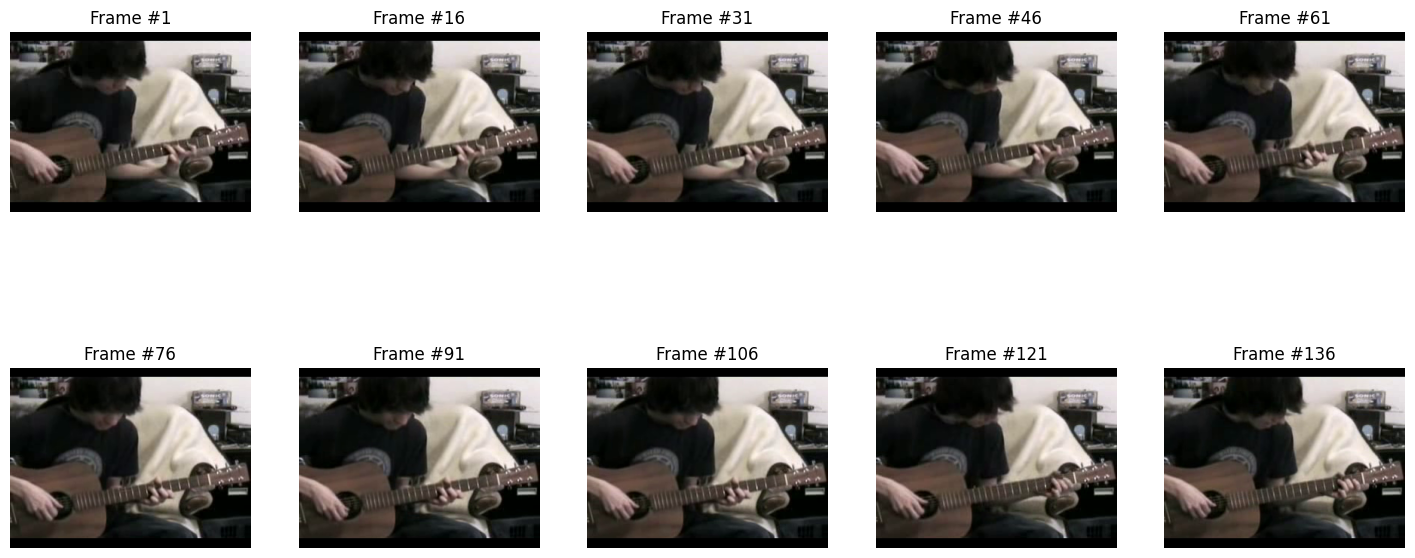

In [13]:
# Display the frames
view_frames(sample_video, frame_step=frame_step)

In [14]:
from torch.utils.data import Dataset, DataLoader

In [15]:
class VideoDataset(Dataset):
    def __init__(self, dataframe, input_frames=10, output_frames=5, stride=3, frame_size=(64, 64), transform=None, color_mode='grayscale'):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing video file paths.
            input_frames (int): Number of input frames.
            output_frames (int): Number of output frames to predict.
            stride (int): Number of frames to skip between sequences.
            frame_size (tuple): Tuple specifying frame width and height (e.g., (64, 64)).
            transform (callable, optional): Optional transform to be applied on a sample.
            color_mode (str): 'grayscale' or 'rgb'.
        """
        self.input_frames = input_frames
        self.output_frames = output_frames
        self.sequence_length = self.input_frames + self.output_frames
        self.stride = stride
        self.transform = transform
        self.color_mode = color_mode
        self.frame_size = frame_size
        self.sequences = []  # List to store sequence information
        self.cached_video = None  # Cache for the currently loaded video
        self.cached_video_path = None  # Path of the cached video

        # Build the sequences list
        for idx, row in dataframe.iterrows():
            video_path = row['clip_path']
            total_frames = self.get_total_frames(video_path)

            if total_frames < self.sequence_length:
                total_sequences = 1  # We'll augment frames later
            else:
                # Calculate the number of sequences with the given stride
                total_sequences = (total_frames - self.sequence_length) // self.stride + 1

            for seq_idx in range(total_sequences):
                start_idx = seq_idx * self.stride
                self.sequences.append({
                    'video_path': video_path,
                    'start_idx': start_idx,
                    'total_frames': total_frames
                })

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence_info = self.sequences[idx]
        video_path = sequence_info['video_path']
        start_idx = sequence_info['start_idx']
        total_frames = sequence_info['total_frames']

        # Check if the video is already cached
        if self.cached_video_path != video_path:
            # Cache the video if it is not already cached
            self.cached_video = self.load_video(video_path)
            self.cached_video_path = video_path

        # Extract frames for the sequence
        end_idx = start_idx + self.sequence_length
        frames = self.cached_video[start_idx:end_idx]

        # Handle cases where frames are missing
        if len(frames) < self.sequence_length:
            frames = self.augment_frames(frames, self.sequence_length)

        # Split into input and target sequences
        input_seq = frames[:self.input_frames]
        target_seq = frames[self.input_frames:]

        # Process sequences
        if self.color_mode == 'grayscale':
            input_seq = input_seq[..., np.newaxis]
            target_seq = target_seq[..., np.newaxis]

        input_seq = input_seq.transpose(0, 3, 1, 2)
        target_seq = target_seq.transpose(0, 3, 1, 2)

        # Convert to tensors and normalize
        input_seq = torch.from_numpy(input_seq).float() / 255.0
        target_seq = torch.from_numpy(target_seq).float() / 255.0

        if self.transform:
            input_seq = self.apply_transform(input_seq)
            target_seq = self.apply_transform(target_seq)

        return {'input': input_seq, 'target': target_seq}

    def load_video(self, video_path):
        """Load the entire video into memory."""
        cap = cv2.VideoCapture(video_path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, self.frame_size)
            if self.color_mode == 'grayscale':
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        return np.array(frames)

    def augment_frames(self, frames, required_length):
        """Augment frames to reach the required sequence length."""
        current_length = len(frames)
        deficit = required_length - current_length

        # Repeat the last frame to fill the deficit
        last_frame = frames[-1] if len(frames) > 0 else np.zeros((self.frame_size[1], self.frame_size[0], 3), dtype=np.uint8)
        augmented_frames = np.concatenate([frames, np.repeat(last_frame[np.newaxis, ...], deficit, axis=0)], axis=0)

        return augmented_frames

    def get_total_frames(self, video_path):
        """Get the total number of frames in a video."""
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return total_frames

    def apply_transform(self, sequence):
        """Apply the transform to each frame in the sequence."""
        transformed_sequence = []
        for frame in sequence:
            frame = self.transform(frame)
            transformed_sequence.append(frame)
        if len(transformed_sequence) == 0:
            raise ValueError("Transformed sequence is empty.")
        transformed_sequence = torch.stack(transformed_sequence)
        return transformed_sequence


In [16]:
# Parameters
batch_size = 16                 # Number of sequences per batch
color_mode = 'rgb'              # or 'grayscale'
input_frames = 5               # Number of input frames
output_frames = 5               # Number of frames to predict
stride = 5                      # 4 frame skip between sequences
frame_size = (64, 64)           # Resize frames to 64x64
num_workers = 0                 # Number of DataLoader workers

In [17]:
import torchvision.transforms as transforms

# Define the normalization transform
if color_mode == 'grayscale':
    transform = transforms.Compose([
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
else:
    transform = transforms.Compose([
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])


In [18]:
# Create datasets
train_dataset = VideoDataset(train_penta_df, input_frames, output_frames, stride, frame_size, transform, color_mode)
val_dataset = VideoDataset(val_penta_df, input_frames, output_frames, stride, frame_size, transform, color_mode)
test_dataset = VideoDataset(test_penta_df, input_frames, output_frames, stride, frame_size, transform, color_mode)

In [19]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [20]:
# Print total number of batches
print(f"Total train batches: {len(train_loader)}")

# Print total number of sequences
print(f"Total train sequences: {len(train_dataset)}")

# Print total number of frames
print(f"Total train frames: {len(train_dataset) * train_dataset.sequence_length}")


Total train batches: 1444
Total train sequences: 23094
Total train frames: 230940


In [21]:
# Fetch a batch
for batch in train_loader:
    input_seq = batch['input']  # Shape: [batch_size, input_frames, channels, height, width]
    target_seq = batch['target']  # Shape: [batch_size, output_frames, channels, height, width]

    print(f"Input sequence shape: {input_seq.shape}")
    print(f"Target sequence shape: {target_seq.shape}")

    # Break after first batch
    break

Input sequence shape: torch.Size([16, 5, 3, 64, 64])
Target sequence shape: torch.Size([16, 5, 3, 64, 64])


In [22]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Add batch dimension

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.encoding[:, :seq_len, :].to(x.device)

class VideoTransformer(nn.Module):
    def __init__(self, input_frames, output_frames, d_model=512, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=2048, frame_size=(64, 64), color_channels=3):
        super(VideoTransformer, self).__init__()
        self.input_frames = input_frames
        self.output_frames = output_frames
        self.d_model = d_model
        self.frame_size = frame_size
        self.color_channels = color_channels

        # Embedding layer for video frames
        self.frame_embed = nn.Linear(color_channels * frame_size[0] * frame_size[1], d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model)

        # Transformer layers
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward),
            num_layers=num_encoder_layers
        )
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward),
            num_layers=num_decoder_layers
        )

        # Output layer to reconstruct frames
        self.output_layer = nn.Linear(d_model, color_channels * frame_size[0] * frame_size[1])

    def forward(self, src, tgt):
        # Flatten and embed input frames
        batch_size, seq_len, channels, height, width = src.size()
        src = src.view(batch_size, seq_len, -1)  # Flatten frames
        src = self.frame_embed(src)

        # Add positional encoding
        src = self.positional_encoding(src)

        # Encode input sequence
        memory = self.encoder(src)

        # Prepare target frames for decoding
        tgt = tgt.view(batch_size, self.output_frames, -1)
        tgt = self.frame_embed(tgt)
        tgt = self.positional_encoding(tgt)

        # Decode output sequence
        output = self.decoder(tgt, memory)

        # Reconstruct frames
        output = self.output_layer(output)
        output = output.view(batch_size, self.output_frames, self.color_channels, self.frame_size[0], self.frame_size[1])
        return output


In [23]:
from torchmetrics.image import StructuralSimilarityIndexMeasure
from tqdm import tqdm

# Initialize model, optimizer, and loss
model = VideoTransformer(input_frames=10, output_frames=5, frame_size=(64, 64), color_channels=3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Training parameters
num_epochs = 100
train_losses, val_losses, ssim_scores = [], [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")
    for batch in train_loader_tqdm:
        inputs = batch['input'].to(device)
        targets = batch['target'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs, targets)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch+1}: Train Loss = {epoch_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss, ssim_score = 0.0, 0.0
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")
    with torch.no_grad():
        for batch in val_loader_tqdm:
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            outputs = model(inputs, targets)

            val_loss += criterion(outputs, targets).item() * inputs.size(0)

            # SSIM computation for each frame
            batch_ssim = 0.0
            for t in range(targets.size(1)):
                target_frame = targets[:, t, :, :, :]
                output_frame = outputs[:, t, :, :, :]
                batch_ssim += ssim_metric(output_frame, target_frame).item()
            batch_ssim /= targets.size(1)
            ssim_score += batch_ssim * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    ssim_score /= len(val_loader.dataset)
    val_losses.append(val_loss)
    ssim_scores.append(ssim_score)

    print(f"Epoch {epoch+1}: Val Loss = {val_loss:.4f}, SSIM = {ssim_score:.4f}")


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch [1/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.08it/s, loss=0.142] 


Epoch 1: Train Loss = 0.2544


Epoch [1/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.33it/s]


Epoch 1: Val Loss = 0.2252, SSIM = 0.0647


Epoch [2/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.13it/s, loss=0.125] 


Epoch 2: Train Loss = 0.1796


Epoch [2/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.51it/s]


Epoch 2: Val Loss = 0.1775, SSIM = 0.0866


Epoch [3/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.32it/s, loss=0.102] 


Epoch 3: Train Loss = 0.1401


Epoch [3/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.02it/s]


Epoch 3: Val Loss = 0.1382, SSIM = 0.1399


Epoch [4/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.24it/s, loss=0.101] 


Epoch 4: Train Loss = 0.1144


Epoch [4/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.38it/s]


Epoch 4: Val Loss = 0.1230, SSIM = 0.1756


Epoch [5/100] Training: 100%|██████████| 1444/1444 [01:33<00:00, 15.48it/s, loss=0.0812]


Epoch 5: Train Loss = 0.0982


Epoch [5/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.09it/s]


Epoch 5: Val Loss = 0.1029, SSIM = 0.2251


Epoch [6/100] Training: 100%|██████████| 1444/1444 [01:32<00:00, 15.54it/s, loss=0.0727]


Epoch 6: Train Loss = 0.0852


Epoch [6/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.18it/s]


Epoch 6: Val Loss = 0.0876, SSIM = 0.2644


Epoch [7/100] Training: 100%|██████████| 1444/1444 [01:32<00:00, 15.57it/s, loss=0.0696]


Epoch 7: Train Loss = 0.0768


Epoch [7/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.50it/s]


Epoch 7: Val Loss = 0.0776, SSIM = 0.3001


Epoch [8/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.35it/s, loss=0.0637]


Epoch 8: Train Loss = 0.0697


Epoch [8/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.04it/s]


Epoch 8: Val Loss = 0.0738, SSIM = 0.3259


Epoch [9/100] Training: 100%|██████████| 1444/1444 [01:33<00:00, 15.38it/s, loss=0.062] 


Epoch 9: Train Loss = 0.0645


Epoch [9/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.84it/s]


Epoch 9: Val Loss = 0.0686, SSIM = 0.3382


Epoch [10/100] Training: 100%|██████████| 1444/1444 [01:33<00:00, 15.43it/s, loss=0.0612]


Epoch 10: Train Loss = 0.0604


Epoch [10/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.47it/s]


Epoch 10: Val Loss = 0.0653, SSIM = 0.3565


Epoch [11/100] Training: 100%|██████████| 1444/1444 [01:33<00:00, 15.50it/s, loss=0.0567]


Epoch 11: Train Loss = 0.0571


Epoch [11/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.12it/s]


Epoch 11: Val Loss = 0.0633, SSIM = 0.3662


Epoch [12/100] Training: 100%|██████████| 1444/1444 [01:33<00:00, 15.50it/s, loss=0.0562]


Epoch 12: Train Loss = 0.0542


Epoch [12/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.31it/s]


Epoch 12: Val Loss = 0.0606, SSIM = 0.3822


Epoch [13/100] Training: 100%|██████████| 1444/1444 [01:32<00:00, 15.53it/s, loss=0.0524] 


Epoch 13: Train Loss = 0.0513


Epoch [13/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.49it/s]


Epoch 13: Val Loss = 0.0597, SSIM = 0.3857


Epoch [14/100] Training: 100%|██████████| 1444/1444 [01:33<00:00, 15.50it/s, loss=0.0555] 


Epoch 14: Train Loss = 0.0499


Epoch [14/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.18it/s]


Epoch 14: Val Loss = 0.0581, SSIM = 0.3919


Epoch [15/100] Training: 100%|██████████| 1444/1444 [01:33<00:00, 15.48it/s, loss=0.0497] 


Epoch 15: Train Loss = 0.0475


Epoch [15/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.20it/s]


Epoch 15: Val Loss = 0.0549, SSIM = 0.4149


Epoch [16/100] Training: 100%|██████████| 1444/1444 [01:33<00:00, 15.49it/s, loss=0.0485] 


Epoch 16: Train Loss = 0.0458


Epoch [16/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.74it/s]


Epoch 16: Val Loss = 0.0546, SSIM = 0.4120


Epoch [17/100] Training: 100%|██████████| 1444/1444 [01:32<00:00, 15.66it/s, loss=0.0465] 


Epoch 17: Train Loss = 0.0443


Epoch [17/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.07it/s]


Epoch 17: Val Loss = 0.0520, SSIM = 0.4276


Epoch [18/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.19it/s, loss=0.0461] 


Epoch 18: Train Loss = 0.0427


Epoch [18/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.77it/s]


Epoch 18: Val Loss = 0.0516, SSIM = 0.4311


Epoch [19/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.33it/s, loss=0.0441] 


Epoch 19: Train Loss = 0.0413


Epoch [19/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.31it/s]


Epoch 19: Val Loss = 0.0495, SSIM = 0.4391


Epoch [20/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.24it/s, loss=0.0435] 


Epoch 20: Train Loss = 0.0401


Epoch [20/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.89it/s]


Epoch 20: Val Loss = 0.0488, SSIM = 0.4476


Epoch [21/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.09it/s, loss=0.0423] 


Epoch 21: Train Loss = 0.0390


Epoch [21/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.47it/s]


Epoch 21: Val Loss = 0.0461, SSIM = 0.4602


Epoch [22/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.10it/s, loss=0.0406] 


Epoch 22: Train Loss = 0.0378


Epoch [22/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.76it/s]


Epoch 22: Val Loss = 0.0465, SSIM = 0.4637


Epoch [23/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.17it/s, loss=0.0399] 


Epoch 23: Train Loss = 0.0373


Epoch [23/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.77it/s]


Epoch 23: Val Loss = 0.0442, SSIM = 0.4756


Epoch [24/100] Training: 100%|██████████| 1444/1444 [01:33<00:00, 15.40it/s, loss=0.04]   


Epoch 24: Train Loss = 0.0360


Epoch [24/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.49it/s]


Epoch 24: Val Loss = 0.0450, SSIM = 0.4699


Epoch [25/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.22it/s, loss=0.0382] 


Epoch 25: Train Loss = 0.0355


Epoch [25/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.95it/s]


Epoch 25: Val Loss = 0.0429, SSIM = 0.4833


Epoch [26/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.34it/s, loss=0.0376] 


Epoch 26: Train Loss = 0.0344


Epoch [26/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.78it/s]


Epoch 26: Val Loss = 0.0420, SSIM = 0.4887


Epoch [27/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.11it/s, loss=0.0372] 


Epoch 27: Train Loss = 0.0337


Epoch [27/100] Validation: 100%|██████████| 236/236 [00:13<00:00, 18.15it/s]


Epoch 27: Val Loss = 0.0421, SSIM = 0.4876


Epoch [28/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.16it/s, loss=0.0382] 


Epoch 28: Train Loss = 0.0329


Epoch [28/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.06it/s]


Epoch 28: Val Loss = 0.0409, SSIM = 0.4973


Epoch [29/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.16it/s, loss=0.0357] 


Epoch 29: Train Loss = 0.0322


Epoch [29/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.21it/s]


Epoch 29: Val Loss = 0.0404, SSIM = 0.4990


Epoch [30/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.11it/s, loss=0.0349] 


Epoch 30: Train Loss = 0.0320


Epoch [30/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.87it/s]


Epoch 30: Val Loss = 0.0393, SSIM = 0.5093


Epoch [31/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.24it/s, loss=0.0347] 


Epoch 31: Train Loss = 0.0311


Epoch [31/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.00it/s]


Epoch 31: Val Loss = 0.0391, SSIM = 0.5096


Epoch [32/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.25it/s, loss=0.0359] 


Epoch 32: Train Loss = 0.0305


Epoch [32/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.40it/s]


Epoch 32: Val Loss = 0.0384, SSIM = 0.5186


Epoch [33/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.15it/s, loss=0.0342] 


Epoch 33: Train Loss = 0.0301


Epoch [33/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.83it/s]


Epoch 33: Val Loss = 0.0381, SSIM = 0.5170


Epoch [34/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.26it/s, loss=0.0331] 


Epoch 34: Train Loss = 0.0296


Epoch [34/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.63it/s]


Epoch 34: Val Loss = 0.0382, SSIM = 0.5198


Epoch [35/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.32it/s, loss=0.0328] 


Epoch 35: Train Loss = 0.0291


Epoch [35/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.96it/s]


Epoch 35: Val Loss = 0.0369, SSIM = 0.5225


Epoch [36/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.25it/s, loss=0.0318] 


Epoch 36: Train Loss = 0.0286


Epoch [36/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.69it/s]


Epoch 36: Val Loss = 0.0364, SSIM = 0.5340


Epoch [37/100] Training: 100%|██████████| 1444/1444 [01:33<00:00, 15.36it/s, loss=0.0319] 


Epoch 37: Train Loss = 0.0282


Epoch [37/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.24it/s]


Epoch 37: Val Loss = 0.0370, SSIM = 0.5235


Epoch [38/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.22it/s, loss=0.0315] 


Epoch 38: Train Loss = 0.0277


Epoch [38/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.88it/s]


Epoch 38: Val Loss = 0.0351, SSIM = 0.5439


Epoch [39/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.30it/s, loss=0.0306] 


Epoch 39: Train Loss = 0.0272


Epoch [39/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.40it/s]


Epoch 39: Val Loss = 0.0355, SSIM = 0.5403


Epoch [40/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.21it/s, loss=0.0319] 


Epoch 40: Train Loss = 0.0269


Epoch [40/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.75it/s]


Epoch 40: Val Loss = 0.0352, SSIM = 0.5421


Epoch [41/100] Training: 100%|██████████| 1444/1444 [01:33<00:00, 15.37it/s, loss=0.0309] 


Epoch 41: Train Loss = 0.0266


Epoch [41/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.95it/s]


Epoch 41: Val Loss = 0.0350, SSIM = 0.5396


Epoch [42/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.31it/s, loss=0.0295] 


Epoch 42: Train Loss = 0.0265


Epoch [42/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.57it/s]


Epoch 42: Val Loss = 0.0339, SSIM = 0.5519


Epoch [43/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.28it/s, loss=0.0289] 


Epoch 43: Train Loss = 0.0257


Epoch [43/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.99it/s]


Epoch 43: Val Loss = 0.0335, SSIM = 0.5533


Epoch [44/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.24it/s, loss=0.0285] 


Epoch 44: Train Loss = 0.0256


Epoch [44/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.96it/s]


Epoch 44: Val Loss = 0.0338, SSIM = 0.5504


Epoch [45/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.34it/s, loss=0.0283] 


Epoch 45: Train Loss = 0.0253


Epoch [45/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.58it/s]


Epoch 45: Val Loss = 0.0335, SSIM = 0.5516


Epoch [46/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.24it/s, loss=0.0287] 


Epoch 46: Train Loss = 0.0249


Epoch [46/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.97it/s]


Epoch 46: Val Loss = 0.0330, SSIM = 0.5578


Epoch [47/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.27it/s, loss=0.0278] 


Epoch 47: Train Loss = 0.0247


Epoch [47/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.46it/s]


Epoch 47: Val Loss = 0.0326, SSIM = 0.5592


Epoch [48/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.33it/s, loss=0.0282] 


Epoch 48: Train Loss = 0.0245


Epoch [48/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.78it/s]


Epoch 48: Val Loss = 0.0327, SSIM = 0.5603


Epoch [49/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.24it/s, loss=0.027]  


Epoch 49: Train Loss = 0.0242


Epoch [49/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.18it/s]


Epoch 49: Val Loss = 0.0313, SSIM = 0.5733


Epoch [50/100] Training: 100%|██████████| 1444/1444 [01:33<00:00, 15.36it/s, loss=0.0262] 


Epoch 50: Train Loss = 0.0238


Epoch [50/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.42it/s]


Epoch 50: Val Loss = 0.0315, SSIM = 0.5704


Epoch [51/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.34it/s, loss=0.027]  


Epoch 51: Train Loss = 0.0236


Epoch [51/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.81it/s]


Epoch 51: Val Loss = 0.0310, SSIM = 0.5739


Epoch [52/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.28it/s, loss=0.0275] 


Epoch 52: Train Loss = 0.0235


Epoch [52/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.86it/s]


Epoch 52: Val Loss = 0.0327, SSIM = 0.5623


Epoch [53/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.33it/s, loss=0.0269] 


Epoch 53: Train Loss = 0.0233


Epoch [53/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.31it/s]


Epoch 53: Val Loss = 0.0308, SSIM = 0.5740


Epoch [54/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.23it/s, loss=0.0258] 


Epoch 54: Train Loss = 0.0229


Epoch [54/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.03it/s]


Epoch 54: Val Loss = 0.0307, SSIM = 0.5768


Epoch [55/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.31it/s, loss=0.0256] 


Epoch 55: Train Loss = 0.0227


Epoch [55/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.20it/s]


Epoch 55: Val Loss = 0.0305, SSIM = 0.5774


Epoch [56/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.27it/s, loss=0.0251] 


Epoch 56: Train Loss = 0.0226


Epoch [56/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.76it/s]


Epoch 56: Val Loss = 0.0300, SSIM = 0.5824


Epoch [57/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.25it/s, loss=0.026]  


Epoch 57: Train Loss = 0.0223


Epoch [57/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.02it/s]


Epoch 57: Val Loss = 0.0300, SSIM = 0.5792


Epoch [58/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.31it/s, loss=0.0247] 


Epoch 58: Train Loss = 0.0221


Epoch [58/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.38it/s]


Epoch 58: Val Loss = 0.0296, SSIM = 0.5860


Epoch [59/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.34it/s, loss=0.0245] 


Epoch 59: Train Loss = 0.0220


Epoch [59/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.90it/s]


Epoch 59: Val Loss = 0.0297, SSIM = 0.5865


Epoch [60/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.16it/s, loss=0.0247] 


Epoch 60: Train Loss = 0.0218


Epoch [60/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.05it/s]


Epoch 60: Val Loss = 0.0291, SSIM = 0.5897


Epoch [61/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.27it/s, loss=0.0244] 


Epoch 61: Train Loss = 0.0216


Epoch [61/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.19it/s]


Epoch 61: Val Loss = 0.0293, SSIM = 0.5879


Epoch [62/100] Training: 100%|██████████| 1444/1444 [01:36<00:00, 14.94it/s, loss=0.0242] 


Epoch 62: Train Loss = 0.0214


Epoch [62/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.73it/s]


Epoch 62: Val Loss = 0.0294, SSIM = 0.5838


Epoch [63/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.10it/s, loss=0.0242] 


Epoch 63: Train Loss = 0.0214


Epoch [63/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.39it/s]


Epoch 63: Val Loss = 0.0295, SSIM = 0.5845


Epoch [64/100] Training: 100%|██████████| 1444/1444 [01:33<00:00, 15.37it/s, loss=0.0237] 


Epoch 64: Train Loss = 0.0213


Epoch [64/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.92it/s]


Epoch 64: Val Loss = 0.0287, SSIM = 0.5901


Epoch [65/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.04it/s, loss=0.0235] 


Epoch 65: Train Loss = 0.0209


Epoch [65/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.32it/s]


Epoch 65: Val Loss = 0.0285, SSIM = 0.5923


Epoch [66/100] Training: 100%|██████████| 1444/1444 [01:36<00:00, 14.96it/s, loss=0.0234] 


Epoch 66: Train Loss = 0.0208


Epoch [66/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.65it/s]


Epoch 66: Val Loss = 0.0286, SSIM = 0.5929


Epoch [67/100] Training: 100%|██████████| 1444/1444 [01:36<00:00, 15.00it/s, loss=0.023]  


Epoch 67: Train Loss = 0.0207


Epoch [67/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.55it/s]


Epoch 67: Val Loss = 0.0280, SSIM = 0.5960


Epoch [68/100] Training: 100%|██████████| 1444/1444 [01:37<00:00, 14.88it/s, loss=0.0235] 


Epoch 68: Train Loss = 0.0205


Epoch [68/100] Validation: 100%|██████████| 236/236 [00:13<00:00, 17.97it/s]


Epoch 68: Val Loss = 0.0281, SSIM = 0.5998


Epoch [69/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.06it/s, loss=0.0238] 


Epoch 69: Train Loss = 0.0205


Epoch [69/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.70it/s]


Epoch 69: Val Loss = 0.0283, SSIM = 0.5976


Epoch [70/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.09it/s, loss=0.0232] 


Epoch 70: Train Loss = 0.0204


Epoch [70/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.31it/s]


Epoch 70: Val Loss = 0.0277, SSIM = 0.6029


Epoch [71/100] Training: 100%|██████████| 1444/1444 [01:36<00:00, 15.01it/s, loss=0.0227] 


Epoch 71: Train Loss = 0.0201


Epoch [71/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.63it/s]


Epoch 71: Val Loss = 0.0274, SSIM = 0.6056


Epoch [72/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.07it/s, loss=0.0229] 


Epoch 72: Train Loss = 0.0202


Epoch [72/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.16it/s]


Epoch 72: Val Loss = 0.0277, SSIM = 0.6014


Epoch [73/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.20it/s, loss=0.023]  


Epoch 73: Train Loss = 0.0199


Epoch [73/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.80it/s]


Epoch 73: Val Loss = 0.0272, SSIM = 0.6060


Epoch [74/100] Training: 100%|██████████| 1444/1444 [01:36<00:00, 14.99it/s, loss=0.0227] 


Epoch 74: Train Loss = 0.0199


Epoch [74/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.59it/s]


Epoch 74: Val Loss = 0.0276, SSIM = 0.6018


Epoch [75/100] Training: 100%|██████████| 1444/1444 [01:36<00:00, 15.03it/s, loss=0.0226] 


Epoch 75: Train Loss = 0.0198


Epoch [75/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.36it/s]


Epoch 75: Val Loss = 0.0271, SSIM = 0.6089


Epoch [76/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.21it/s, loss=0.0221] 


Epoch 76: Train Loss = 0.0197


Epoch [76/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.73it/s]


Epoch 76: Val Loss = 0.0271, SSIM = 0.6048


Epoch [77/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.14it/s, loss=0.0225] 


Epoch 77: Train Loss = 0.0196


Epoch [77/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.36it/s]


Epoch 77: Val Loss = 0.0272, SSIM = 0.6035


Epoch [78/100] Training: 100%|██████████| 1444/1444 [01:37<00:00, 14.88it/s, loss=0.0224] 


Epoch 78: Train Loss = 0.0195


Epoch [78/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.36it/s]


Epoch 78: Val Loss = 0.0272, SSIM = 0.6004


Epoch [79/100] Training: 100%|██████████| 1444/1444 [01:36<00:00, 14.93it/s, loss=0.0226] 


Epoch 79: Train Loss = 0.0195


Epoch [79/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.17it/s]


Epoch 79: Val Loss = 0.0268, SSIM = 0.6084


Epoch [80/100] Training: 100%|██████████| 1444/1444 [01:36<00:00, 15.04it/s, loss=0.0218] 


Epoch 80: Train Loss = 0.0193


Epoch [80/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.58it/s]


Epoch 80: Val Loss = 0.0262, SSIM = 0.6151


Epoch [81/100] Training: 100%|██████████| 1444/1444 [01:36<00:00, 14.99it/s, loss=0.0222] 


Epoch 81: Train Loss = 0.0192


Epoch [81/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.62it/s]


Epoch 81: Val Loss = 0.0269, SSIM = 0.6103


Epoch [82/100] Training: 100%|██████████| 1444/1444 [01:36<00:00, 14.90it/s, loss=0.0217] 


Epoch 82: Train Loss = 0.0193


Epoch [82/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.66it/s]


Epoch 82: Val Loss = 0.0263, SSIM = 0.6141


Epoch [83/100] Training: 100%|██████████| 1444/1444 [01:36<00:00, 15.00it/s, loss=0.0221] 


Epoch 83: Train Loss = 0.0190


Epoch [83/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.80it/s]


Epoch 83: Val Loss = 0.0266, SSIM = 0.6070


Epoch [84/100] Training: 100%|██████████| 1444/1444 [01:36<00:00, 15.01it/s, loss=0.0218] 


Epoch 84: Train Loss = 0.0190


Epoch [84/100] Validation: 100%|██████████| 236/236 [00:13<00:00, 18.05it/s]


Epoch 84: Val Loss = 0.0263, SSIM = 0.6144


Epoch [85/100] Training: 100%|██████████| 1444/1444 [01:36<00:00, 15.02it/s, loss=0.0216] 


Epoch 85: Train Loss = 0.0189


Epoch [85/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.72it/s]


Epoch 85: Val Loss = 0.0260, SSIM = 0.6167


Epoch [86/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.11it/s, loss=0.0216] 


Epoch 86: Train Loss = 0.0189


Epoch [86/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.37it/s]


Epoch 86: Val Loss = 0.0262, SSIM = 0.6144


Epoch [87/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.27it/s, loss=0.0215] 


Epoch 87: Train Loss = 0.0188


Epoch [87/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.81it/s]


Epoch 87: Val Loss = 0.0256, SSIM = 0.6202


Epoch [88/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.18it/s, loss=0.0214] 


Epoch 88: Train Loss = 0.0187


Epoch [88/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 19.02it/s]


Epoch 88: Val Loss = 0.0258, SSIM = 0.6188


Epoch [89/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.28it/s, loss=0.0211] 


Epoch 89: Train Loss = 0.0186


Epoch [89/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.31it/s]


Epoch 89: Val Loss = 0.0256, SSIM = 0.6190


Epoch [90/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.31it/s, loss=0.0212] 


Epoch 90: Train Loss = 0.0186


Epoch [90/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.91it/s]


Epoch 90: Val Loss = 0.0254, SSIM = 0.6224


Epoch [91/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.22it/s, loss=0.0213] 


Epoch 91: Train Loss = 0.0184


Epoch [91/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.17it/s]


Epoch 91: Val Loss = 0.0257, SSIM = 0.6189


Epoch [92/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.20it/s, loss=0.0213] 


Epoch 92: Train Loss = 0.0184


Epoch [92/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.95it/s]


Epoch 92: Val Loss = 0.0256, SSIM = 0.6189


Epoch [93/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.22it/s, loss=0.0212] 


Epoch 93: Train Loss = 0.0184


Epoch [93/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.72it/s]


Epoch 93: Val Loss = 0.0257, SSIM = 0.6156


Epoch [94/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.25it/s, loss=0.0215] 


Epoch 94: Train Loss = 0.0184


Epoch [94/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.22it/s]


Epoch 94: Val Loss = 0.0254, SSIM = 0.6212


Epoch [95/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.24it/s, loss=0.0213] 


Epoch 95: Train Loss = 0.0184


Epoch [95/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.96it/s]


Epoch 95: Val Loss = 0.0251, SSIM = 0.6246


Epoch [96/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.16it/s, loss=0.0214] 


Epoch 96: Train Loss = 0.0182


Epoch [96/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.41it/s]


Epoch 96: Val Loss = 0.0252, SSIM = 0.6247


Epoch [97/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.28it/s, loss=0.0213] 


Epoch 97: Train Loss = 0.0183


Epoch [97/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.81it/s]


Epoch 97: Val Loss = 0.0252, SSIM = 0.6246


Epoch [98/100] Training: 100%|██████████| 1444/1444 [01:35<00:00, 15.11it/s, loss=0.0214] 


Epoch 98: Train Loss = 0.0182


Epoch [98/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.93it/s]


Epoch 98: Val Loss = 0.0249, SSIM = 0.6265


Epoch [99/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.22it/s, loss=0.0214] 


Epoch 99: Train Loss = 0.0180


Epoch [99/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.34it/s]


Epoch 99: Val Loss = 0.0253, SSIM = 0.6216


Epoch [100/100] Training: 100%|██████████| 1444/1444 [01:34<00:00, 15.23it/s, loss=0.0209] 


Epoch 100: Train Loss = 0.0181


Epoch [100/100] Validation: 100%|██████████| 236/236 [00:12<00:00, 18.69it/s]

Epoch 100: Val Loss = 0.0253, SSIM = 0.6222


In [ ]:
print(f"Model Architecture:\n{model}\n")

In [26]:
def save_model_and_metrics(model, train_losses, val_losses, ssim_scores, filepath='/kaggle/working/video_transformer_model.pth'):
    """
    Save the model state, optimizer state, and training metrics.
    
    Args:
        model (nn.Module): The trained model
        train_losses (list): List of training losses per epoch
        val_losses (list): List of validation losses per epoch
        ssim_scores (list): List of SSIM scores per epoch
        filepath (str): Path to save the model checkpoint
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'ssim_scores': ssim_scores,
        'epoch': len(train_losses)
    }
    
    torch.save(checkpoint, filepath)
    print(f"Model and metrics saved to {filepath}")

# Call this function after training is complete
save_model_and_metrics(model, train_losses, val_losses, ssim_scores)

Model and metrics saved to /kaggle/working/video_transformer_model.pt


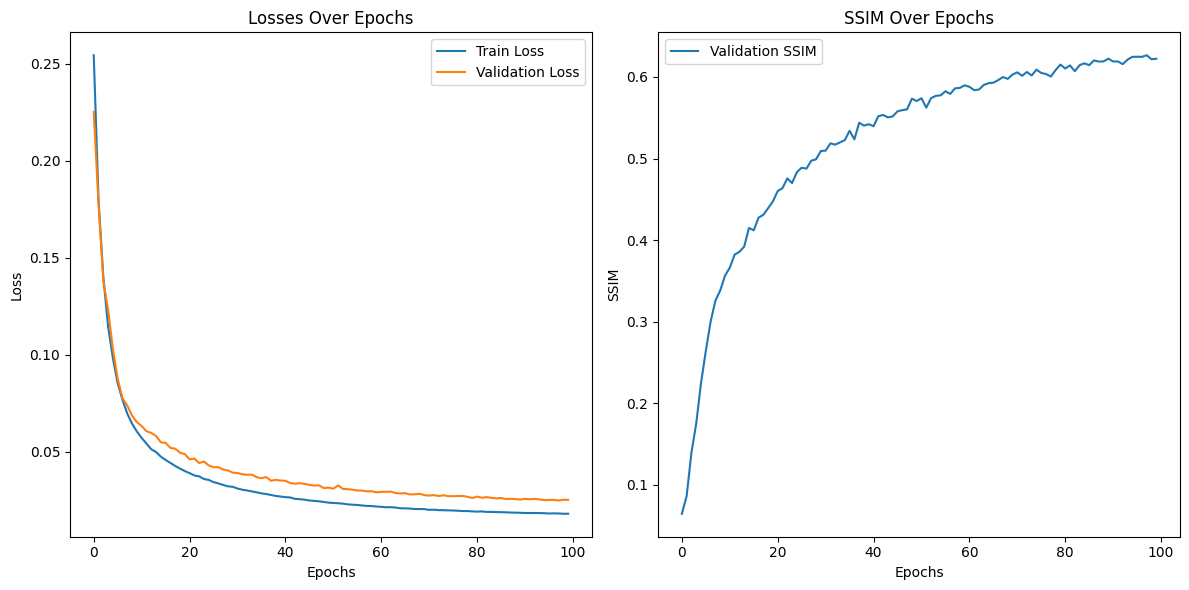

In [27]:
# Plot losses and SSIM scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Losses Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(ssim_scores, label="Validation SSIM")
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.legend()
plt.title("SSIM Over Epochs")

plt.tight_layout()
plt.show()



In [ ]:
from torchmetrics.image import StructuralSimilarityIndexMeasure
from tqdm import tqdm

model = VideoTransformer(input_frames=10, output_frames=5, frame_size=(64, 64), color_channels=3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Load the weights into the model
checkpoint = torch.load('video_transformer_model.pth', map_location=torch.device('cpu'))

# Load the model weights into the model
model.load_state_dict(checkpoint['model_state_dict'])

# Move model to CPU and set it to evaluation mode (optional since it's already on CPU)
model = model.to('cpu')

In [29]:
# Testing loop
model.eval()  # Set model to evaluation mode
test_loss, test_ssim = 0.0, 0.0
test_loader_tqdm = tqdm(test_loader, desc="Testing")

with torch.no_grad():
    for batch in test_loader_tqdm:
        # Move data to the device
        inputs = batch['input'].to(device)
        targets = batch['target'].to(device)
        
        # Forward pass
        outputs = model(inputs, targets)
        
        # Loss computation
        batch_loss = criterion(outputs, targets).item()
        test_loss += batch_loss * inputs.size(0)
        
        # SSIM computation for each frame
        batch_ssim = 0.0
        for t in range(targets.size(1)):  # Iterate over sequence frames
            target_frame = targets[:, t, :, :, :]
            output_frame = outputs[:, t, :, :, :]
            batch_ssim += ssim_metric(output_frame, target_frame).item()
        batch_ssim /= targets.size(1)
        test_ssim += batch_ssim * inputs.size(0)
        
        test_loader_tqdm.set_postfix(loss=batch_loss, ssim=batch_ssim)

# Average the loss and SSIM over the dataset
test_loss /= len(test_loader.dataset)
test_ssim /= len(test_loader.dataset)

print(f"Test Loss = {test_loss:.4f}, Test SSIM = {test_ssim:.4f}")


Testing: 100%|██████████| 247/247 [00:13<00:00, 17.87it/s, loss=0.0361, ssim=0.606] 

Test Loss = 0.0269, Test SSIM = 0.6125


In [8]:
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image


In [16]:
# Function to denormalize images
def denormalize(tensor):
    # Assumes the input tensor was normalized with mean=0.5 and std=0.5
    tensor = tensor * 0.5 + 0.5
    tensor = torch.clamp(tensor, 0, 1)  # Ensures pixel values are between 0 and 1
    return tensor

# Function to resize tensor images
def resize_tensor(tensor, size, interpolation=Image.BILINEAR):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((size[1], size[0]), interpolation=interpolation),  # Correct order for PIL
        transforms.ToTensor()
    ])
    return transform(tensor)

# Sharpening function
def sharpen_image(image):
    """Apply a sharpening filter to the image."""
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=np.float32)
    sharpened_image = cv2.filter2D(image, -1, kernel)
    return sharpened_image

In [17]:
def predict_and_display_video_sequences(video_path, num_sequences, model, device, input_frames=10, output_frames=5, frame_size=(64,64), display_size=(320,240), isSharpening=True):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return

    total_frames_in_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((frame_size[1], frame_size[0])),  # Correct order for PIL
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize for RGB frames
    ])

    sequences_processed = 0
    frame_idx = 0  # Current frame index

    while sequences_processed < num_sequences and frame_idx + input_frames <= total_frames_in_video:
        # Set the frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        # Read input frames
        input_frame_list = []
        for _ in range(input_frames):
            ret, frame = cap.read()
            if not ret:
                print("End of video reached or cannot read the frame.")
                break
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
            input_frame_list.append(frame_rgb)

        if len(input_frame_list) < input_frames:
            print("Not enough input frames. Ending.")
            break

        # Preprocess input frames
        input_frames_tensor = []
        for frame in input_frame_list:
            frame_tensor = preprocess(frame)
            input_frames_tensor.append(frame_tensor)
        input_frames_tensor = torch.stack(input_frames_tensor)  # Shape: (input_frames, channels, H, W)
        input_frames_tensor = input_frames_tensor.unsqueeze(0).to(device)  # Add batch dimension

        # Predict frames using the model
        model.eval()
        with torch.no_grad():
            predicted_frames = model(input_frames_tensor)  # Shape: (1, output_frames, channels, H, W)
        predicted_frames = predicted_frames.squeeze(0).cpu()  # Shape: (output_frames, channels, H, W)

        # Denormalize and resize frames for display
        resized_input_frames = []
        for frame_tensor in input_frames_tensor.squeeze(0).cpu():
            denorm_frame = denormalize(frame_tensor)
            resized_frame = resize_tensor(denorm_frame, display_size, cv2.INTER_LANCZOS4)
            resized_input_frames.append(resized_frame)

        # Predicted frames (with or without sharpening based on isSharpening flag)
        resized_predicted_frames = []
        for frame_tensor in predicted_frames:
            denorm_frame = denormalize(frame_tensor)
            resized_frame = resize_tensor(denorm_frame, display_size, cv2.INTER_LANCZOS4)

            if isSharpening:  # Apply sharpening if isSharpening is True
                sharpened_frame = sharpen_image(resized_frame.permute(1, 2, 0).numpy())  # Apply sharpening
                # Clip to [0, 255] for display (since we're using imshow)
                sharpened_frame = np.clip(sharpened_frame, 0, 255)
                resized_predicted_frames.append(torch.from_numpy(sharpened_frame).permute(2, 0, 1))
            else:
                resized_predicted_frames.append(resized_frame)

        # Display frames in a grid
        fig_rows = 2  # Input frames in the first row, predicted frames in the second row
        fig_cols = max(input_frames, output_frames)
        fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(fig_cols * 2, fig_rows * 2))

        # Display input frames
        for i in range(fig_cols):
            if i < len(resized_input_frames):
                frame = resized_input_frames[i].permute(1, 2, 0).numpy()
                frame = np.clip(frame, 0, 1)  # Ensure values are between [0, 1] for imshow
                axs[0, i].imshow(frame)
                axs[0, i].set_title(f'Input Frame {i+1}')
            else:
                axs[0, i].axis('off')
            axs[0, i].axis('off')

        # Display predicted frames
        for i in range(fig_cols):
            if i < len(resized_predicted_frames):
                frame = resized_predicted_frames[i].permute(1, 2, 0).numpy()
                frame = np.clip(frame, 0, 1)  # Ensure values are between [0, 1] for imshow
                axs[1, i].imshow(frame)
                axs[1, i].set_title(f'Predicted Frame {i+1}')
            else:
                axs[1, i].axis('off')
            axs[1, i].axis('off')

        plt.tight_layout()
        plt.show()

        sequences_processed += 1

        # Advance the frame index to the next sequence
        frame_idx += input_frames + output_frames  # Skip over the predicted frames

        # Check if there are enough frames left for the next sequence
        if frame_idx + input_frames > total_frames_in_video:
            print("Not enough frames left to process the next sequence.")
            break

    cap.release()
    print("Processing complete.")


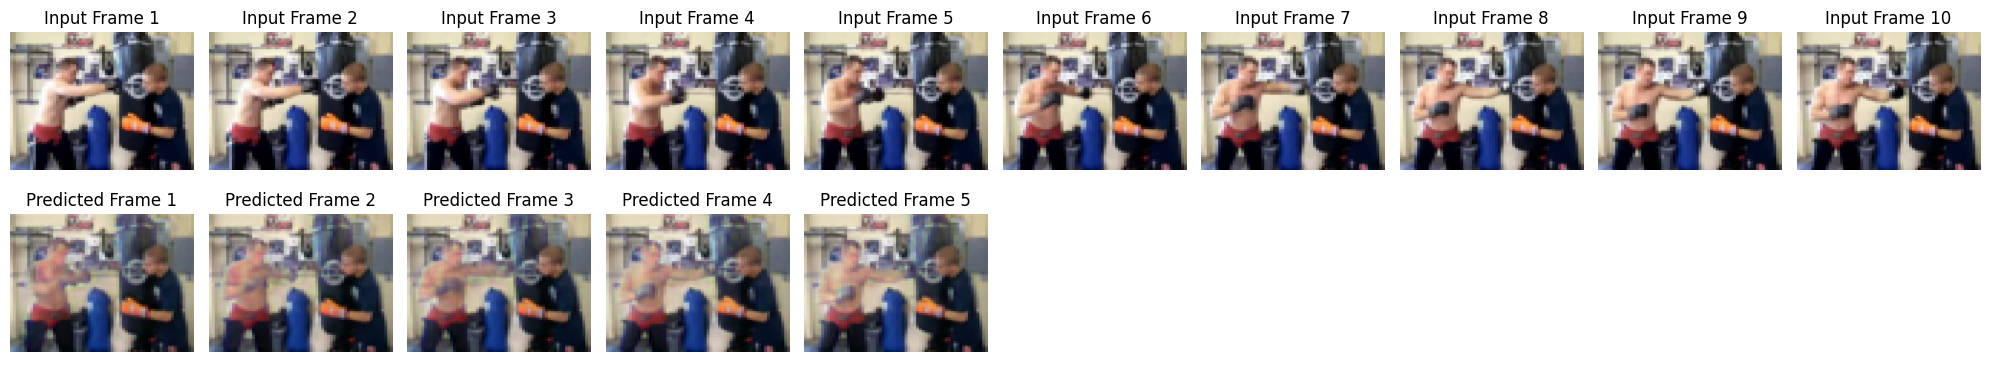

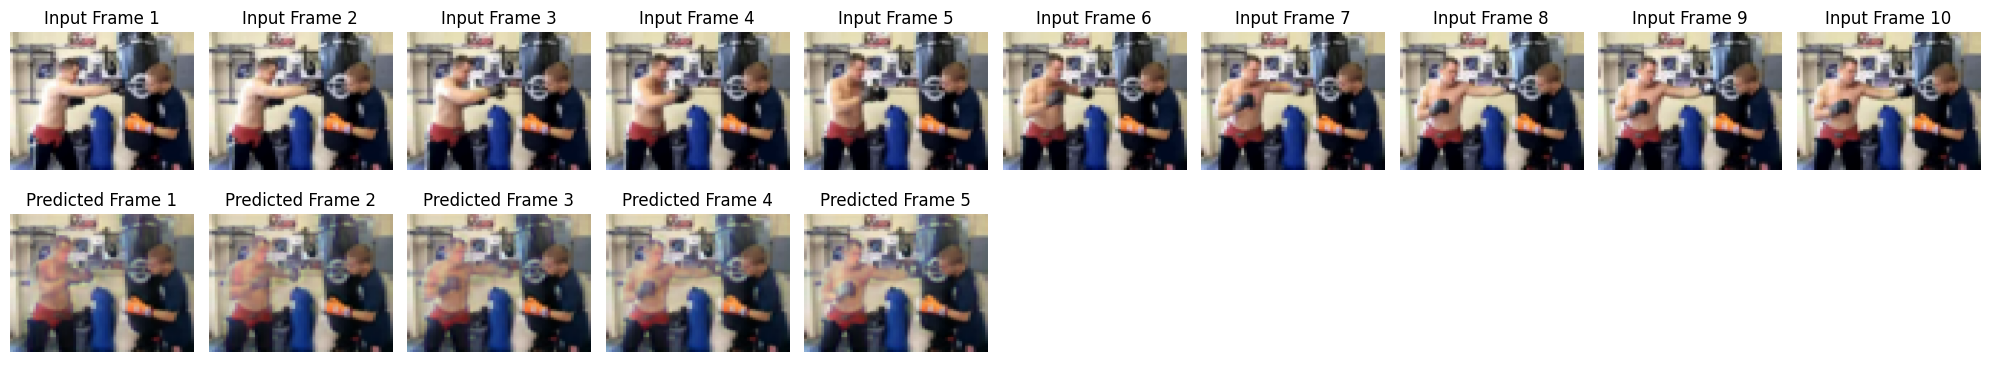

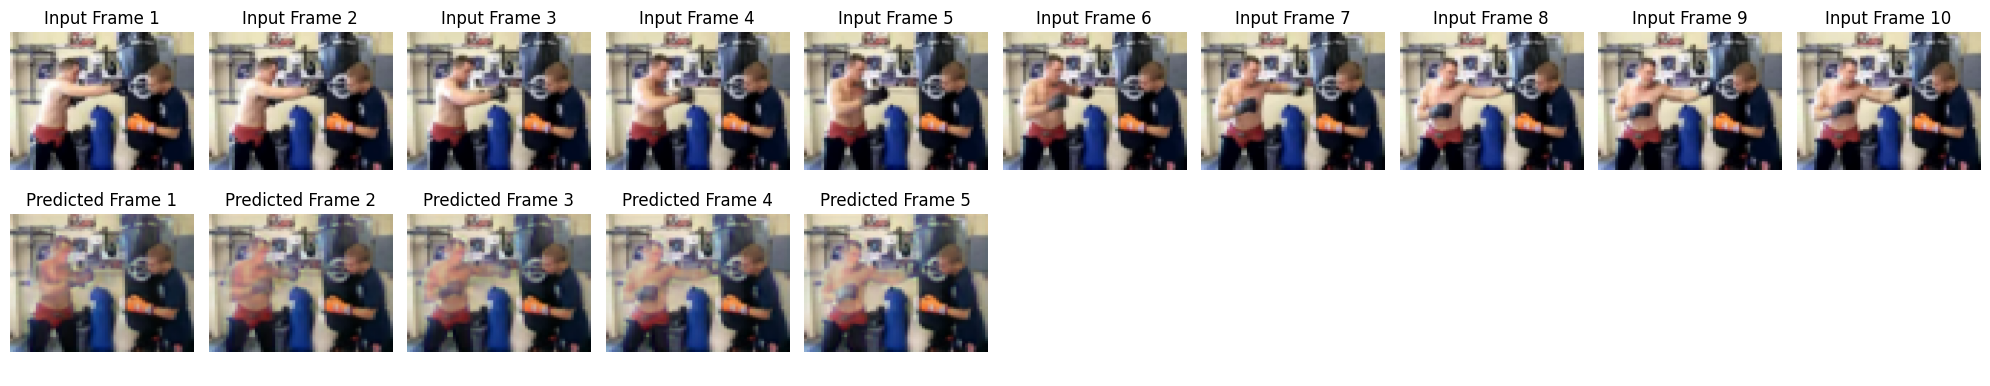

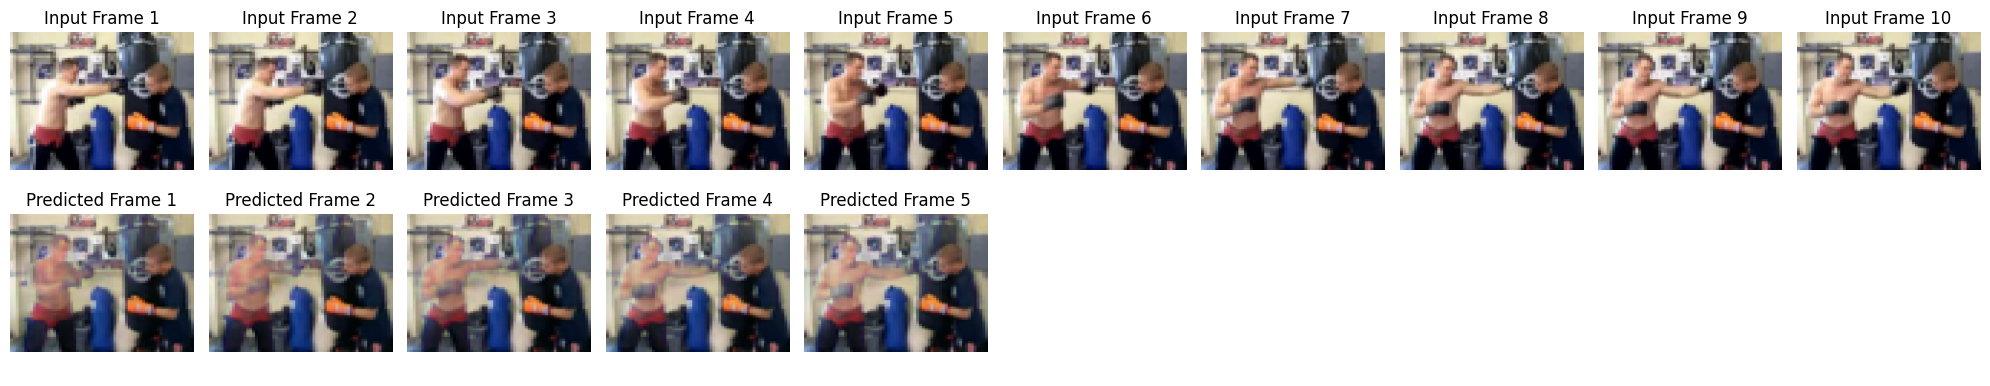

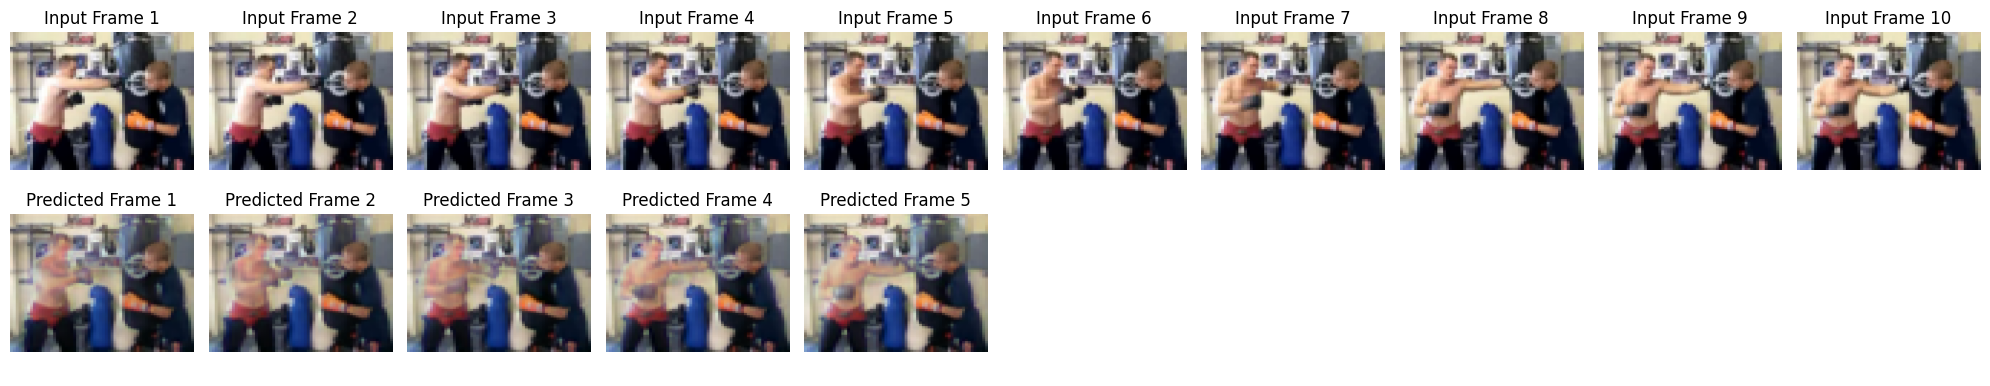

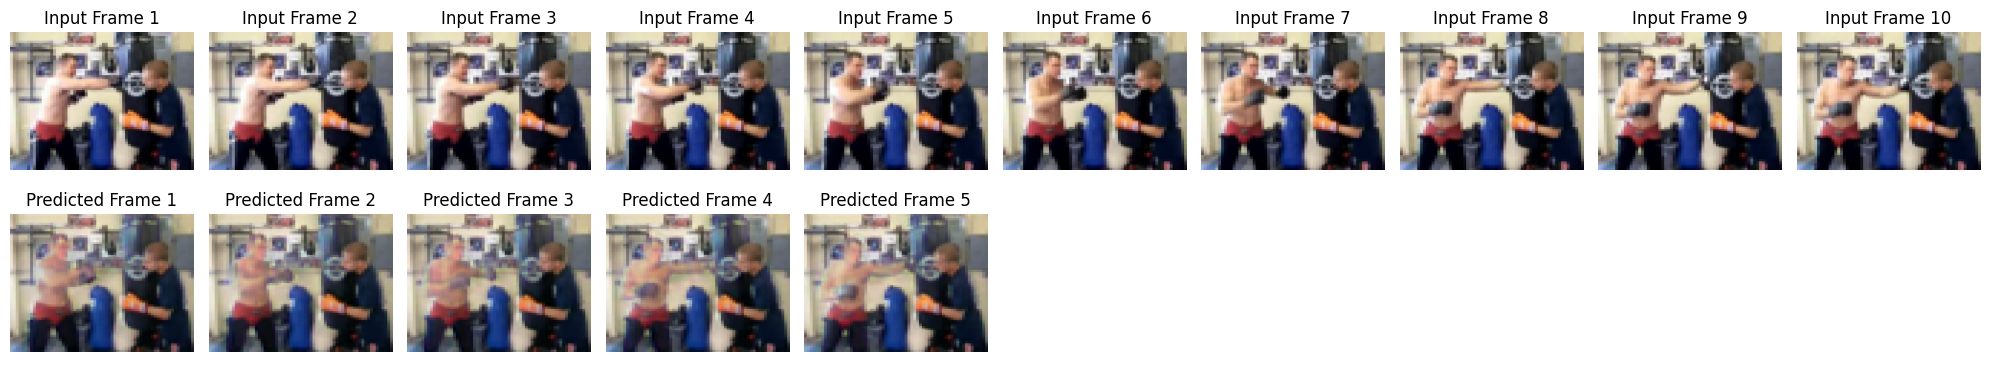

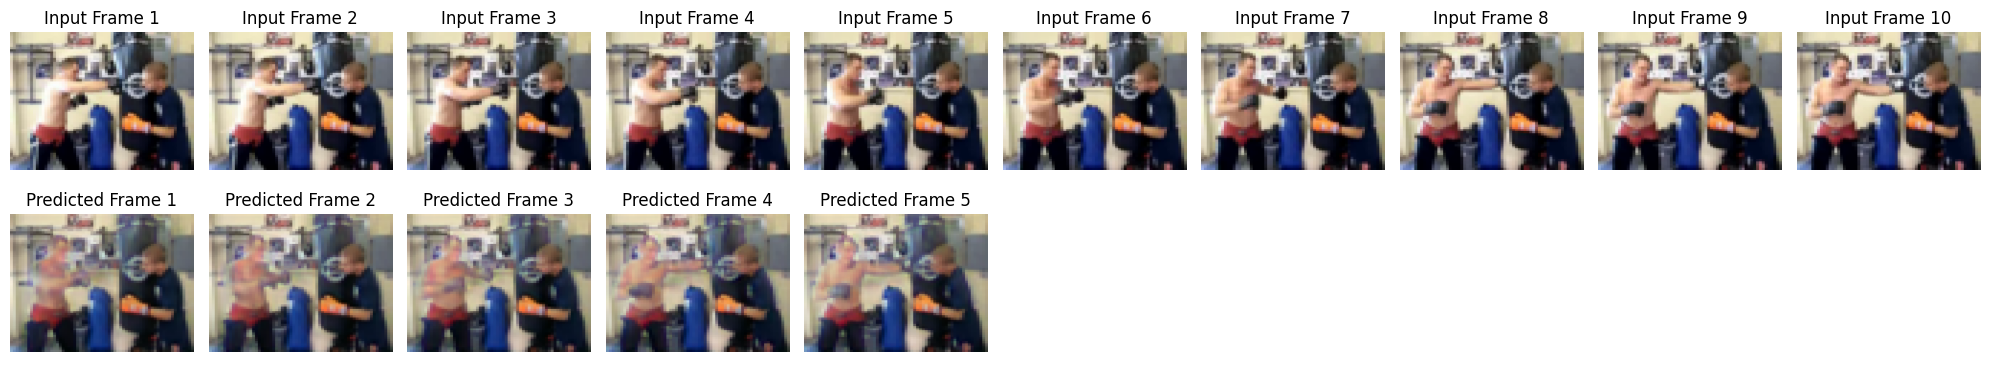

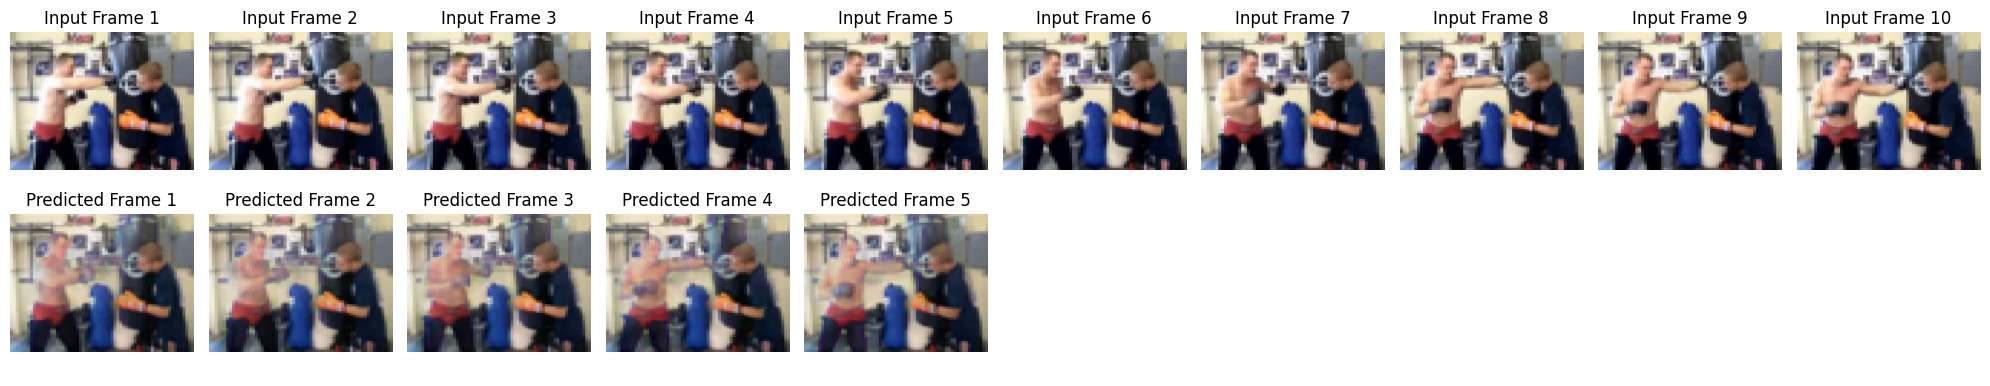

Processing complete.


In [18]:
video_path = '../data/test/BoxingPunchingBag/v_BoxingPunchingBag_g04_c02.avi'
num_sequences = 8  # Number of sequences to process

predict_and_display_video_sequences(
    video_path=video_path,
    num_sequences=num_sequences,
    model=model,
    device=device,
    input_frames=10,
    output_frames=5,
    frame_size=(64, 64),
    display_size=(320, 240),
    isSharpening=False  # Disable sharpening
)

In [19]:

def generate_video(model, video_path, output_path, frame_size=(320, 240), frame_rate=30, input_frames=10, output_frames=5):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    # Open the input video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return

    total_frames_in_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, frame_rate, (frame_size[0], frame_size[1]))

    # Preprocessing transforms
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),  # Model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Assuming RGB frames
    ])

    current_sequence = 0  # Sequence counter

    while True:
        # Read input frames
        input_frame_list = []
        for _ in range(input_frames):
            ret, frame = cap.read()
            if not ret:
                print("End of video reached or cannot read the frame.")
                break
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            input_frame_list.append(frame_rgb)

        if len(input_frame_list) < input_frames:
            print("Not enough input frames. Ending.")
            break

        # Preprocess input frames
        input_frames_tensor = []
        for frame in input_frame_list:
            frame_tensor = preprocess(frame)
            input_frames_tensor.append(frame_tensor)
        input_frames_tensor = torch.stack(input_frames_tensor)  # Shape: (input_frames, C, H, W)
        input_frames_tensor = input_frames_tensor.unsqueeze(0).to(device)  # Shape: (1, input_frames, C, H, W)

        # Predict frames
        with torch.no_grad():
            predicted_frames = model(input_frames_tensor)  # Shape: (1, output_frames, C, H, W)
        predicted_frames = predicted_frames.squeeze(0).cpu()  # Shape: (output_frames, C, H, W)

        # Denormalize and resize frames
        input_frames_denorm = denormalize(input_frames_tensor.squeeze(0).cpu())
        predicted_frames_denorm = denormalize(predicted_frames)

        # Resize frames to desired output size
        resized_input_frames = []
        for frame in input_frames_denorm:
            resized_frame = resize_tensor(frame, frame_size)
            resized_input_frames.append(resized_frame)
        resized_predicted_frames = []
        for frame in predicted_frames_denorm:
            resized_frame = resize_tensor(frame, frame_size)
            resized_predicted_frames.append(resized_frame)

        # Convert tensors to numpy arrays and BGR format for OpenCV
        for frame in resized_input_frames:
            frame_np = frame.permute(1, 2, 0).numpy()
            frame_np = np.clip(frame_np * 255.0, 0, 255).astype(np.uint8)
            frame_bgr = cv2.cvtColor(frame_np, cv2.COLOR_RGB2BGR)
            out.write(frame_bgr)

        for frame in resized_predicted_frames:
            frame_np = frame.permute(1, 2, 0).numpy()
            frame_np = np.clip(frame_np * 255.0, 0, 255).astype(np.uint8)
            frame_bgr = cv2.cvtColor(frame_np, cv2.COLOR_RGB2BGR)
            out.write(frame_bgr)

        # Skip the actual frames that correspond to predicted frames
        for _ in range(output_frames):
            ret, frame = cap.read()
            if not ret:
                print("End of video reached or cannot read the frame.")
                break

        # Check if there are enough frames left to process the next sequence
        pos_frames = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        if pos_frames + input_frames > total_frames_in_video:
            print("Not enough frames left to process the next sequence.")
            break

        current_sequence += 1

    # Release resources
    cap.release()
    out.release()
    print(f'Video saved to {output_path}')


In [20]:

video_path = '../data/test/BoxingPunchingBag/v_BoxingPunchingBag_g22_c06.avi'
output_path = 'output_video.mp4'

generate_video(
    model=model,
    video_path=video_path,
    output_path=output_path,
    frame_size=(320, 240),  # Output video size (width, height)
    frame_rate=30,          # Adjust as needed
    input_frames=10,
    output_frames=5
)


End of video reached or cannot read the frame.
Not enough frames left to process the next sequence.
Video saved to output_video.mp4
